In [12]:
import pandas as pd
import numpy as np
import sqlite3
from  pathlib import Path
import matplotlib.pyplot as plt

pq_path = Path("../data_processed/movies_clean.parquet")
df = pd.read_parquet(pq_path)

db_path = Path("../data_processed/imdb_movies.db")
con = sqlite3.connect(db_path)

df.shape, df.head()

((4919, 29),
    color           director  num_critic_for_reviews  runtime_min  \
 0  Color      James Cameron                   723.0        178.0   
 1  Color     Gore Verbinski                   302.0        169.0   
 2  Color         Sam Mendes                   602.0        148.0   
 3  Color  Christopher Nolan                   813.0        164.0   
 4    nan        Doug Walker                     NaN          NaN   
 
    director_facebook_likes  actor_3_facebook_likes      actor_2_name  \
 0                      0.0                   855.0  Joel David Moore   
 1                    563.0                  1000.0     Orlando Bloom   
 2                      0.0                   161.0      Rory Kinnear   
 3                  22000.0                 23000.0    Christian Bale   
 4                    131.0                     NaN        Rob Walker   
 
    actor_1_facebook_likes    gross_usd                           genres  ...  \
 0                  1000.0  760505847.0  Action|Ad

## Column Detection
The step below ensures the correct year and ratings columns are selected, even if the dataset uses slightly different names. Using a helper function tests candidate names, confirming the ones available in the dataset. This adds flexibility to the pipeline. 

In [45]:
def pick_year_col(df):
    candidates = ["title_year","year","release_year","movie_year","year_released"]
    for c in candidates:
        if c in df.columns:
            return c
 
    for c in df.columns:
        if "year" in c.lower():
            return c
    return None

def pick_rating_col(df):
    preferred = ["imdb_rating","rating","imdb_score","score"]
    bad_tokens = {"content", "advisory", "mpaa", "certificate"}
    def is_numeric_0_10(s):
        x = pd.to_numeric(s, errors = "coerce")
        x = x[( x >= 0) & (x <= 10)]
        return x.notna().mean() > 0.6  

    for c in preferred:
        if c in df.columns and is_numeric_0_10(df[c]):
            return c

    for c in df.columns:
        cl = c.lower()
        if any(k in cl for k in ["rating","score"]) and not any(t in cl for t in bad_tokens):
            if is_numeric_0_10(df[c]):
                return c
    return None

year_col   = pick_year_col(df)
rating_col = pick_rating_col(df)

print("Using columns → year:", year_col, "| rating:", rating_col)
assert year_col is not None and rating_col is not None, "Could not find suitable year/rating columns."

Using columns → year: year | rating: rating


## Column Detection for Inconsistent Naming - Shown Below 
The dataset contains variations in column names (e.g., gross, gross_usd, and revenue). To make the notebook more robust and reusable, I added logic to automatically detect column names using pattern matching shown in the 3 following cells. 

I perfomed this by scanning all columns for applicable keywords, refining detection with regrex-based matching, and built a helper function to generalize the approcach. 

This ensures the pipeline still works even if column names differ slightly across datasets. 

In [46]:
[c for c in df.columns if any(k in c.lower() for k in
    ["budget","gross","revenue","income","box","world","domestic","usa","rating","score","imdb"])]


import re
[c for c in df.columns if re.search(r"(gross|revenue|box[_ ]?office|world)", c, re.I)]


def pick_by_regex(patterns):
    for col in df.columns:
        for pat in patterns:
            if re.search(pat, col, re.I):
                return col
    return None

revenue_col = pick_by_regex([r"gross", r"revenue", r"box[_ ]?office", r"world"])
print("Detected revenue column:", revenue_col)
assert revenue_col, "Couldn't detect a revenue/gross column—print df.columns to inspect."



Detected revenue column: gross_usd


## Column Discovery
To handle column name variations, I started scanning for keywords like year, release, and rating. This quick diagnostic shows which columns are potential matches. From there, I used more robust logic to finalize which column(s) to use. 

In [47]:
[c for c in df.columns if any(k in c.lower() for k in ["year", "date", "release", "score", "rating"])]

['content_rating', 'year', 'rating']

In [48]:
[c for c in ["decade", "gross_usd", "num_voted_users", "imdb_score"] if c not in df.columns]

['imdb_score']

## Cleaning Shown Below: Budget, Revenue & Ratings
Before analysis, I ensured numeric columns were properly converted, handled missing values, and capped extreme outliers at the 95th percentile. This step below makes later visualizations such as budget vs. revenue trends more interpretable. 

In [ ]:
import numpy as np
import pandas as pd

year_col    = "decade"          
budget_col  = "gross_usd"       
revenue_col = "num_voted_users" 
rating_candidates = ["imdb_score", "imdb_rating", "avg_vote", "mean_vote"]
rating_col = next((c for c in rating_candidates if c in df.columns), None)

print("Selected ->",
      f"year = {year_col}", 
      f"budget = {budget_col}",
      f"revenue = {revenue_col}",
      f"rating = {rating_col}")


cols = [c for c in [year_col, budget_col, revenue_col, rating_col] if c and c in df.columns]
base = df[cols].copy()

for c in [x for x in [budget_col, revenue_col, rating_col] if x in base.columns]:
    base[c] = pd.to_numeric(base[c], errors = "coerce")

required = [x for x in [year_col, budget_col, revenue_col] if x in base.columns]
if required:
    base = base.dropna(subset = required)

if budget_col in base.columns:
    cap_b = base[budget_col].quantile(0.95)
    base[budget_col] = np.minimum(base[budget_col], cap_b)

if revenue_col in base.columns:
    cap_r = base[revenue_col].quantile(0.95)
    base[revenue_col] = np.minimum(base[revenue_col], cap_r)

base.head()





Selected -> year = decade budget = gross_usd revenue = num_voted_users rating = None


,decade,gross_usd,num_voted_users
0,2000,1.775404e+08,364642.6
1,2000,1.775404e+08,364642.6
2,2010,1.775404e+08,275868.0
3,2010,1.775404e+08,364642.6
5,2010,7.305868e+07,212204.0


## Missing Value Summary
This table below shows the total number and percentage of missing values for each column, sorted most to least missing. 

In [49]:
na_summary = (
    df.isna().sum()
        .to_frame("missing_count")
        .assign(missing_pct = lambda t: (t["missing_count"] / len(df)).round(3))
        .sort_values("missing_count", ascending = False)
)
na_summary

,missing_count,missing_pct
gross_usd,863,0.17
budget_usd,485,0.10
aspect_ratio,326,0.07
year,106,0.02
decade,106,0.02
director_facebook_likes,102,0.02
num_critic_for_reviews,49,0.01
actor_3_facebook_likes,23,0.01
num_user_for_reviews,21,0.00
runtime_min,15,0.00


### Descriptive Statistics (Numeric Columns)
This summary provides key statistics for all numeric fields, including count, mean, standard deviation, and distribution percentiles (25%, 50%, 75%). Values are formatted for easier readability, highlighting the sale of variables such as budget, revenue and user votes. 

In [50]:
desc = df.describe(include='number').T
display(
    desc.style.format({
        'mean': '{:,.2f}', 'std': '{:,.2f}',
        'min': '{:,.0f}',  '25%': '{:,.0f}', '50%': '{:,.0f}',
        '75%': '{:,.0f}',  'max': '{:,.0f}',
    })
)


,count,mean,std,min,25%,50%,75%,max
num_critic_for_reviews,4870.000000,138.01,120.25,1,49,108,191,813
runtime_min,4904.000000,107.09,25.28,7,93,103,118,511
director_facebook_likes,4817.000000,690.71,"2,832.11",0,7,48,190,"23,000"
actor_3_facebook_likes,4896.000000,630.96,"1,625.43",0,132,366,633,"23,000"
actor_1_facebook_likes,4912.000000,"6,490.88","15,103.08",0,607,982,"11,000","640,000"
gross_usd,4056.000000,"47,621,564.12","67,363,868.56",162,"5,008,728","25,035,665","61,099,406","760,505,847"
num_voted_users,4919.000000,"82,618.20","138,285.85",5,"8,356","33,158","93,758","1,689,764"
cast_total_facebook_likes,4919.000000,"9,574.65","18,159.99",0,"1,394","3,044","13,612","656,730"
facenumber_in_poster,4906.000000,1.38,2.02,0,0,1,2,43
num_user_for_reviews,4898.000000,267.60,372.84,1,64,154,320,"5,060"


### Exploratory Check: Movie Counts by Decade
Before moving into SQL queries, I performed an exploratory check to confirm the structure, distribution, and missing values of the dataset. A quick decade-based count confirms the data aligns with expectations, in addition to a large rise in production from the 1980's onward. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4919 entries, 0 to 4918
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   color                      4919 non-null   object 
 1   director                   4919 non-null   object 
 2   num_critic_for_reviews     4870 non-null   float64
 3   runtime_min                4904 non-null   float64
 4   director_facebook_likes    4817 non-null   float64
 5   actor_3_facebook_likes     4896 non-null   float64
 6   actor_2_name               4919 non-null   object 
 7   actor_1_facebook_likes     4912 non-null   float64
 8   gross_usd                  4056 non-null   float64
 9   genres                     4919 non-null   object 
 10  actor_1_name               4919 non-null   object 
 11  title                      4919 non-null   object 
 12  num_voted_users            4919 non-null   int64  
 13  cast_total_facebook_likes  4919 non-null   int64

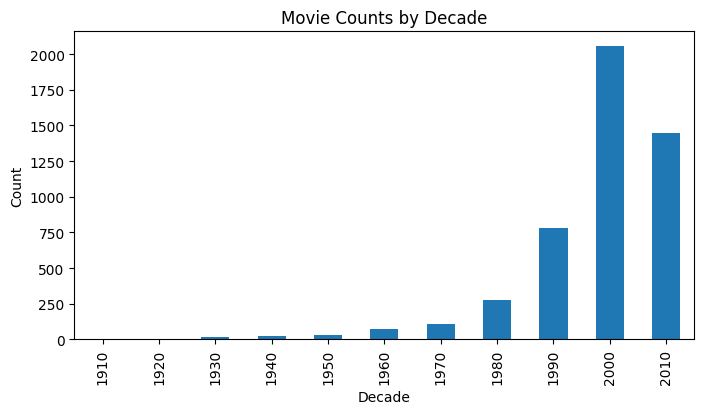

In [51]:

df.info()
df.isna().sum().sort_values(ascending = False).head(10)
df.describe(include = "all").transpose().head(15)

print("\nMissing values (top 10):")
print(df.isna().sum().sort_values(ascending = False).head(10))

print("\nDescriptive stats (first 15 rows):")
print(df.describe(include = "all").transpose().head(15))

import matplotlib.pyplot as plt 

df['decade'].value_counts().sort_index().plot(kind = "bar", figsize = (8, 4))
plt.title("Movie Counts by Decade")
plt.xlabel("Decade")
plt.ylabel("Count")
plt.show()

### Data Dictionary Overview
This table lists all dataset columns with their data type and percentage of missing values. It provides a quick reference for understanding variable structure and potential data quality issues before deeper analysis. 

In [52]:
data_dict = pd.DataFrame({
    "column": df.columns,
    "dtype": df.dtypes.astype(str).values,
    "pct_missing": [df[c].isna().mean() 
    for c in df.columns]
})
data_dict

,column,dtype,pct_missing
0,color,object,0.00
1,director,object,0.00
2,num_critic_for_reviews,float64,0.01
3,runtime_min,float64,0.00
4,director_facebook_likes,float64,0.02
5,actor_3_facebook_likes,float64,0.00
6,actor_2_name,object,0.00
7,actor_1_facebook_likes,float64,0.00
8,gross_usd,float64,0.18
9,genres,object,0.00


## Query 1: Movies per Decade 

In [53]:
sql = """

SELECT (year / 10) * 10 AS decade_start,
printf('%d0s', (year / 10)) AS decade_label,
COUNT(*) AS movie_count
FROM titles
WHERE year BETWEEN 1970 and 2020
GROUP BY decade_start
ORDER BY decade_start;
"""

## Chart 1: Movies per Decade (Without Labels)
The bar chart below shows the distribution of movies across decades. By plotting counts without value labels, the focus stays on the overall trend - a sharp increase in movie producion starting in the 1980's, peaking in the 2000's. This version is cleaner for scanning the big picture quickly.

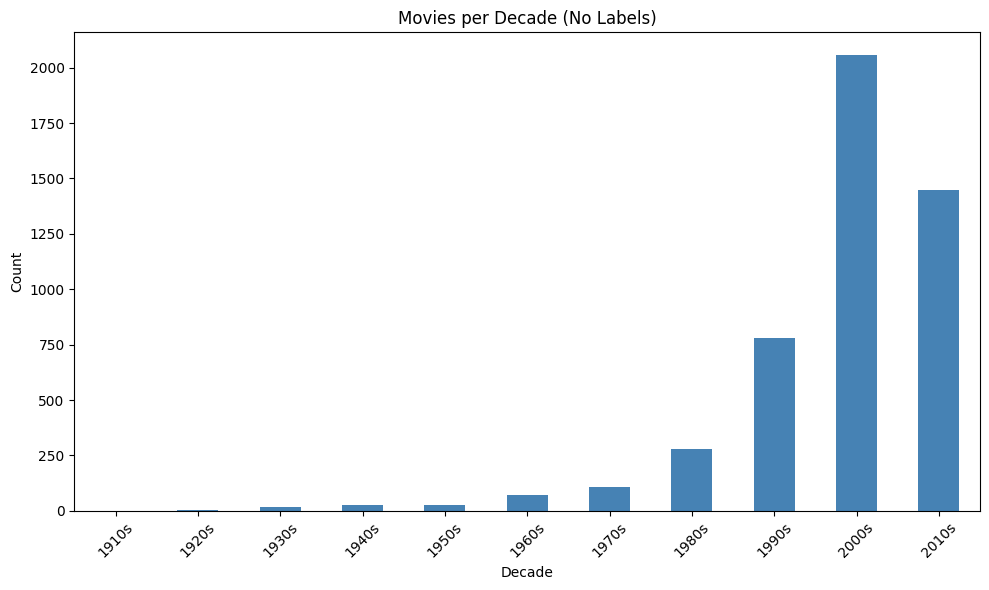

In [54]:
import matplotlib.pyplot as plt

s = df['decade'].value_counts().sort_index().rename('movie_count')
s.index = s.index.astype(int).map(lambda d: f"{d}s")  


plt.figure(figsize = (10, 6))
ax = s.plot(kind = 'bar', color = 'steelblue')
ax.set_title("Movies per Decade (No Labels)")
ax.set_xlabel("Decade")
ax.set_ylabel("Count")
plt.xticks(rotation =45)
plt.tight_layout()
plt.savefig("../visuals/movies_per_decade_nolabels.png", dpi = 300, bbox_inches = "tight")
plt.show()

## Chart 1.1 : Movies per Decade (With Labels)
The chart version below includes value labels above each bar, making the exact counts visible. While slightly busier visually, it helps stakeholders quickly reference numbers without estimating from the y-axis. Using both versions demonstrates flexibiity in tailoring visuals for exploratory analysis vs. presentation needs. 

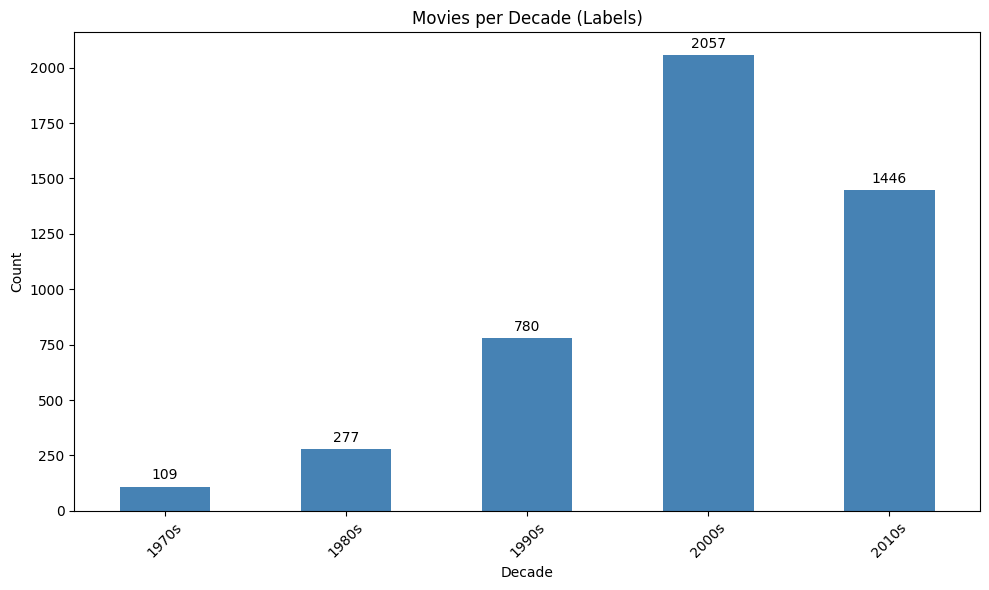

In [ ]:
plt.figure(figsize=(10,6))
ax = s.plot(kind='bar', color='steelblue')
ax.set_title("Movies per Decade (Labels)")
ax.set_xlabel("Decade")
ax.set_ylabel("Count")
plt.xticks(rotation=45)

# value labels
for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}",
                (p.get_x() + p.get_width()/2, p.get_height()),
                ha="center", va="bottom", xytext=(0,3), textcoords="offset points")

plt.tight_layout()
plt.savefig("../visuals/movies_per_decade_labels.png", dpi=300, bbox_inches="tight")
plt.show()


## Query 2: Top 10 Movie Genres

In [55]:
sql = """

SELECT
    genre,
    COUNT(*) AS movie_count
FROM title_genres
GROUP BY genre
ORDER BY movie_count DESC
LIMIT 10;
"""

In [56]:
normalize_map = {
    'sci fi': 'Sci-Fi',
    'sci-fi': 'Sci-Fi',
    'science fiction': 'Sci-Fi',
    'romcom': 'Romance',
    'rom-com': 'Romance',
    'crime drama': 'Crime',
    'action/adventure': 'Action',
}

g = (
    df['genres'].astype(str).str.strip()
      .str.lower()
      .replace({'': pd.NA, 'nan': pd.NA, 'none': pd.NA})
)

delim = '|' if g.str.contains(r'\|', na=False).any() else ','

genre_long = (
    g.dropna()
     .str.split(delim)
     .explode()
     .str.strip()
     .replace(normalize_map)
     .str.title()
)

genre_long = genre_long[genre_long.notna() & (genre_long != '')]

counts = genre_long.value_counts()
top_n = 10
top_genres = counts.head(top_n).rename_axis('genre').rename('count').reset_index()
top_genres['share_pct'] = (top_genres['count'] / counts.sum() * 100).round(1)

top_genres.to_csv("../visuals/top_genres_top10.csv", index=False)

top_genres

,genre,count,share_pct
0,Drama,2535,17.90
1,Comedy,1848,13.10
2,Thriller,1364,9.70
3,Action,1113,7.90
4,Romance,1084,7.70
5,Adventure,888,6.30
6,Crime,869,6.10
7,Sci-Fi,595,4.20
8,Fantasy,583,4.10
9,Horror,540,3.80


## Chart 2: Top 10 Most Common Genres
The chart below shows the distribution of the top 10 most common movie genres in the dataset. *Drama* dominates by a wide margin, followed by *Comedy*, *Thriller*, and *Action*. Genres like *Sci-Fi*, *Fantasy*, and *Horror* appear less frequently. This breakdown higlights the strong industry emphasis on story-driven genres (Drama/Comedy), while niche categories remain under-represented. 

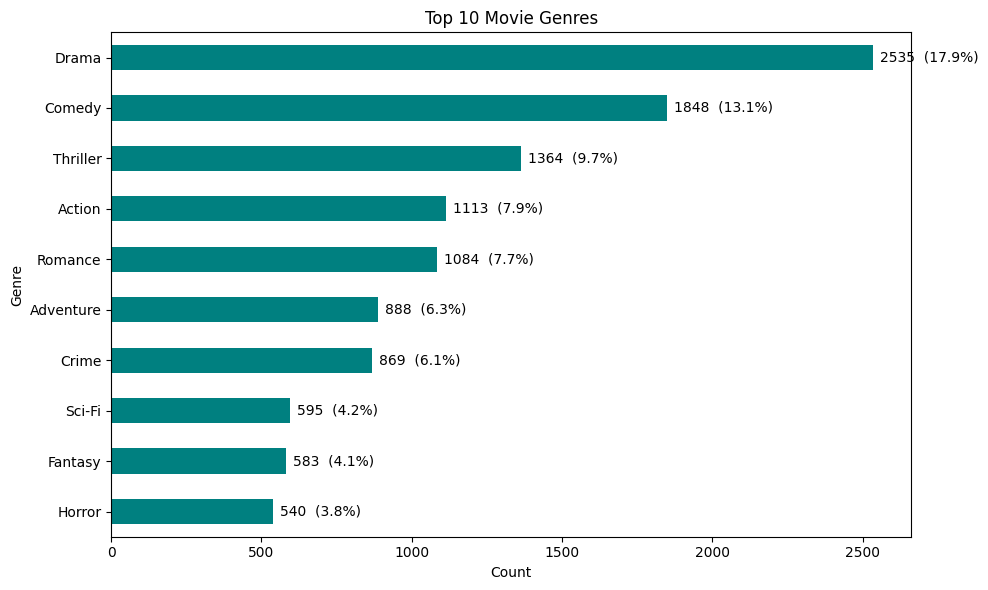

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10, 6))
ax = top_genres.set_index('genre')['count'].sort_values(ascending = True).plot(
    kind = 'barh', color = 'teal'
)
ax.set_title("Top 10 Movie Genres")
ax.set_xlabel("Count")
ax.set_ylabel("Genre")

for p, pct in zip(ax.patches, top_genres.sort_values('count')['share_pct'].tolist()):
    ax.annotate(f"{int(p.get_width())}  ({pct}%)",
                (p.get_width(), p.get_y() + p.get_height() / 2),
                va = 'center', ha = 'left', xytext = (5, 0), textcoords = 'offset points')

plt.tight_layout()
plt.savefig("../visuals/top_genres.png", dpi = 300, bbox_inches = "tight")
plt.show()

### Query 3: IMDb Ratings Distribution
This query selects IMDb ratings from the dataset, ensuring that only valid values between 0 and 10 are included. By casting the ratings to numeric values and filtering nulls, the data is cleaned and ready for analysis. 

In [58]:
sql = ''' 

SELECT CAST(rating AS REAL) AS rating
FROM titles_with_ratings
WHERE rating IS NOT NULL
    AND rating BETWEEN 0 AND 10;
'''


## Chart 3: Ratings Distribution (bell curve)
The bell-shaped curve below shows how IMDb ratings roughly follow a normal distribution. About 68% of movies fall within one standard versin of the mean rating (~6-7), 95% within two standard deviations (~5-8), and 99.7% within three (~4-9). This illustrates the 68-95-99.7 rule, confirming that most ratings cluster near the average, with fewer movies receiving very low or very high ratings. 

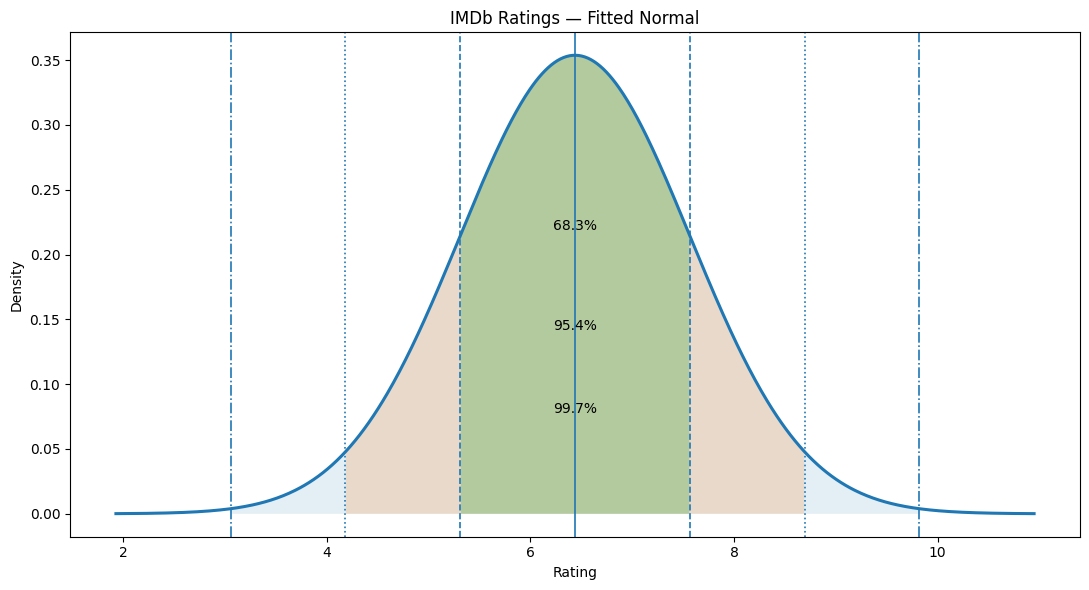

In [59]:
import numpy as np
from math import erf, sqrt

s = pd.to_numeric(df['rating'], errors = 'coerce').dropna()
s = s[(s >= 0) & (s <= 10)]
mu, sigma = s.mean(), s.std(ddof = 1)

xs = np.linspace(mu - 4 * sigma, mu + 4 * sigma, 600)
pdf = (1 / (sigma*np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((xs-mu) / sigma) **2)


def cdf(x): return 0.5*(1 + erf((x-mu)/(sigma*sqrt(2))))

plt.figure(figsize = (11,6))


for k, alpha in zip([3,2,1], [0.12, 0.18, 0.28]): 
    lo, hi = mu - k * sigma, mu + k * sigma
    plt.fill_between(xs, 0, pdf, where = (xs >= lo) & (xs <= hi), alpha = alpha)

plt.plot(xs, pdf, linewidth = 2.2)
for x, style in [(mu,'-'), (mu-sigma,'--'), (mu+sigma,'--'),
                 (mu-2*sigma,':'), (mu+2*sigma,':'),
                 (mu-3*sigma,'-.') , (mu+3*sigma,'-.')]:
    plt.axvline(x, linestyle = style, linewidth = 1.2)

ymax = pdf.max()
p1 = cdf(mu + sigma) - cdf(mu - sigma)
p2 = cdf(mu + 2 * sigma) - cdf(mu - 2 * sigma)
p3 = cdf(mu + 3 * sigma) - cdf(mu - 3 * sigma)
plt.text(mu, ymax * 0.62, f"{p1 * 100:.1f}%", ha = 'center')
plt.text(mu, ymax * 0.40, f"{p2 *100:.1f}%", ha = 'center')
plt.text(mu, ymax * 0.22, f"{p3 *100:.1f}%", ha = 'center')

plt.title("IMDb Ratings — Fitted Normal")
plt.xlabel("Rating"); plt.ylabel("Density")
plt.tight_layout()
plt.savefig("../visuals/ratings_normal_curve.png", dpi = 300, bbox_inches = "tight")
plt.show()

## Query 4: Top 20 Actors by Film Count 
This query identifies actors with the highest number of film appearances. By grouping the dataset by actor name and counting their film credits, the actors can be ranked and extracted at the top 20. This helps point out prolific actors and provides insight into casting frequency across the dataset. 

In [60]:
sql = '''

SELECT actor_name, COUNT(*) AS film_count
FROM roles
GROULP BY actor_name
ORDER BY film_count DESC
LIMIT 20;
'''

In [61]:
actor_cols = [c for c in df.columns if ("actor" in c.lower()) and c.lower().endswith("_name")]
id_cols    = [c for c in ["tconst", "title_id", "id", "movie_id"] if c in df.columns]

actors_long = df[id_cols + actor_cols].melt(
    id_vars=id_cols, value_vars=actor_cols,
    var_name="slot", value_name="actor"
)

actors_long["actor"] = (
    actors_long["actor"].astype(str).str.strip()
    .replace({"": np.nan, "nan": np.nan, "NaN": np.nan, "NONE": np.nan, "None": np.nan, "N/A": np.nan})
)

actors_long = actors_long.dropna(subset=["actor"])

if id_cols:
    actors_long = actors_long.drop_duplicates(id_cols + ["actor"])


actors_long["actor_norm"] = (
    actors_long["actor"].str.replace(r"\s+", " ", regex=True).str.title()
)

top_actors = (
    actors_long["actor_norm"]
    .value_counts()
    .head(20)
    .rename_axis("actor")
    .reset_index(name="film_count")
)

display(top_actors)


,actor,film_count
0,Robert De Niro,53
1,Morgan Freeman,43
2,Bruce Willis,38
3,Matt Damon,37
4,Steve Buscemi,36
5,Johnny Depp,36
6,Brad Pitt,33
7,Nicolas Cage,33
8,Will Ferrell,32
9,Liam Neeson,32


## Chart 4: Top 20 Actors by Film
The bar chart below visualizes the top 20 actors ranked by their number of film appearances. It clearly shows which actors have consistently appeared in the most films, with counts annotated for quick references. This visualization highlights the most prolific actors in the dataset and provides a strightforward way to compare film counts at a glance. 

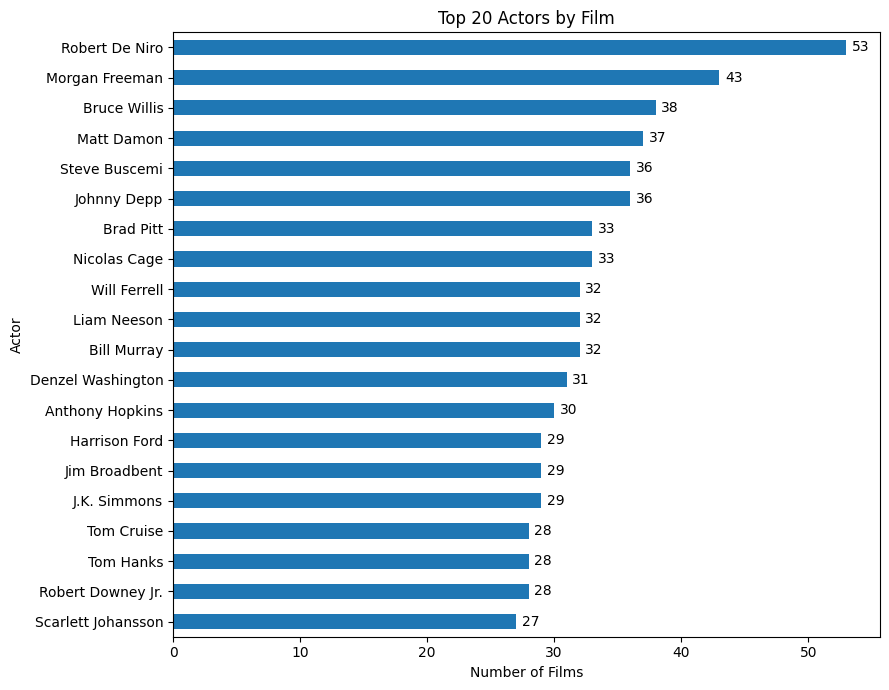

Saved to: figures/top_actors_by_count.png


In [62]:
from pathlib import Path



plot_df = top_actors.copy()
plot_df = plot_df[
    plot_df["actor"].notna() &
    ~plot_df["actor"].astype(str).str.strip().str.lower().isin(["nan", "none", "n/a", ""])
]

fig_dir = Path("figures")
fig_dir.mkdir(parents = True, exist_ok = True)
out_file = fig_dir / "top_actors_by_count.png"

ax = plot_df.sort_values("film_count").plot(kind = "barh", x = "actor", y = "film_count", figsize = (9, 7))
ax.set_title("Top 20 Actors by Film")
ax.set_xlabel("Number of Films")
ax.set_ylabel("Actor")
if ax.legend_: 
    ax.legend_.remove()
for p in ax.patches:
    ax.annotate(f"{int(p.get_width())}",
                (p.get_width(), p.get_y() + p.get_height()/2),
                va = "center", ha = "left", xytext = (4, 0), textcoords = "offset points")
plt.tight_layout()
plt.savefig(out_file, dpi = 300, bbox_inches = "tight")
plt.show()
print("Saved to:", out_file)


## Query 5: Average IMDb Ratings by Year
After detecting the year and rating columns, the data is cleaned and average IMDb ratings per year are calculated. This provides a long-term view of rating trends across decades of film history. 

In [63]:
year_col = "year"
rating_col = "rating"

tmp = df[[year_col, rating_col]].copy()

tmp[year_col] = pd.to_numeric(tmp[year_col], errors = "coerce")
tmp[rating_col] = pd.to_numeric(tmp[rating_col], errors = "coerce")

ratings_by_year = (
    tmp.dropna(subset = [year_col, rating_col])
        .groupby(year_col, as_index = False)[rating_col].mean()
        .rename(columns = {year_col: "year", rating_col: "avg_rating"})
        .sort_values("year")
)
ratings_by_year.head()

,year,avg_rating
0,"1,916.00",8.00
1,"1,920.00",4.80
2,"1,925.00",8.30
3,"1,927.00",8.30
4,"1,929.00",7.15


## Chart 5: Ratings by Year
The chart below calculates the average IMDb ratings by year without titles. It highlights how audience ratings fluctuated over time, helping to identify broader trends (e.g., whether more recent films tend to score highter or lower compared to earlier years). 

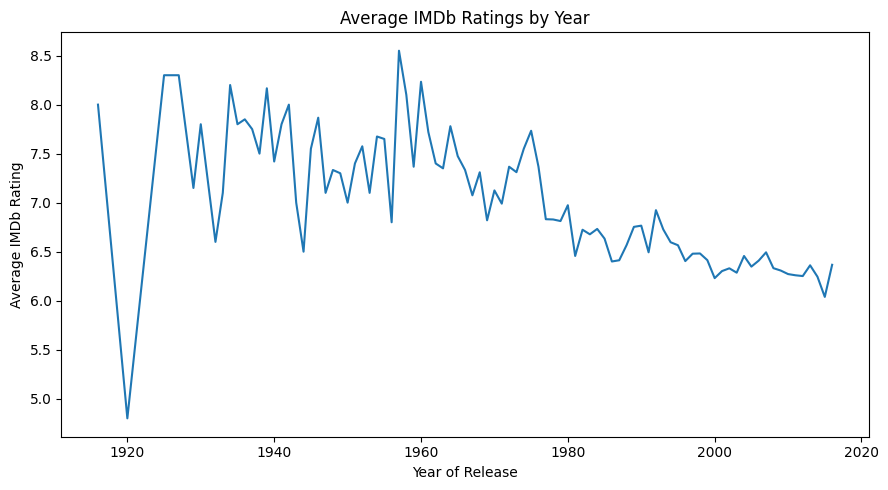

In [64]:
fig_dir = Path("figures"); fig_dir.mkdir(exist_ok = True, parents = True)
out_file = fig_dir / "avg_rating_by_year.png"

plt.figure(figsize = (9, 5))
plt.plot(ratings_by_year["year"], ratings_by_year["avg_rating"])
plt.xlabel("Year of Release")
plt.ylabel("Average IMDb Rating")
plt.title("Average IMDb Ratings by Year")
plt.tight_layout()
plt.savefig(out_file, dpi = 200, bbox_inches = "tight")
plt.show()


## Query 6: Budget vs Revenue by Year (Average)

In [65]:
from pathlib import Path

db_path = Path("../data_raw/imdb_movies.db").resolve()
db_path, db_path.exists()

(PosixPath('/Users/mymac/Documents/DataProjects/IMDb-EndToEnd/data_raw/imdb_movies.db'),
 True)

In [66]:
pd.read_sql_query("PRAGMA table_info(movie_metadata);", conn)

,cid,name,type,notnull,dflt_value,pk
0,0,color,TEXT,0,None,0
1,1,director_name,TEXT,0,None,0
2,2,num_critic_for_reviews,REAL,0,None,0
3,3,duration,REAL,0,None,0
4,4,director_facebook_likes,REAL,0,None,0
5,5,actor_3_facebook_likes,REAL,0,None,0
6,6,actor_2_name,TEXT,0,None,0
7,7,actor_1_facebook_likes,REAL,0,None,0
8,8,gross,REAL,0,None,0
9,9,genres,TEXT,0,None,0


In [67]:
sql = """
SELECT
    CAST(title_year AS INTEGER) AS year,
    AVG(CAST(budget AS REAL)) AS avg_budget_usd,
    AVG(CAST(gross  AS REAL)) AS avg_revenue_usd
FROM movie_metadata
WHERE title_year BETWEEN 1970 AND 2020
  AND budget IS NOT NULL AND budget <> ''
  AND gross  IS NOT NULL AND gross  <> ''
GROUP BY year
ORDER BY year;
"""

pd.options.display.float_format = '{:,.2f}'.format

import sqlite3
with sqlite3.connect(db_path) as conn:
    df_budget_rev = pd.read_sql_query(sql, conn)

df_budget_rev.head()


,year,avg_budget_usd,avg_revenue_usd
0,1970,"12,875,000.00","10,450,000.00"
1,1971,"4,181,750.00","27,247,057.75"
2,1972,"3,005,000.00","67,501,217.50"
3,1973,"4,355,400.00","102,919,529.00"
4,1974,"4,581,009.14","55,052,942.86"


## Chart 6: Budget vs. Revenue
The scatterplot above shows the relationship between production budget and worldwide gross revenue. As expeccted, larger budgets often correlate with highter revenue, but there are also many lower budgeted films that achieved strong box office returns. It's a useful lens for understanding financial risk and reward in filmmaking. 

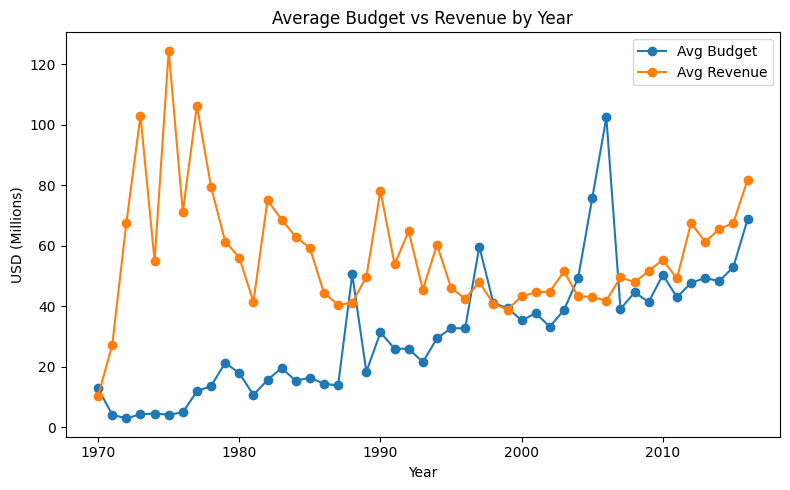

In [ ]:
from pathlib import Path
import matplotlib.pyplot as plt

trend = df_budget_rev.sort_values("year").copy()

trend["avg_budget_m"]  = trend["avg_budget_usd"]  / 1e6
trend["avg_revenue_m"] = trend["avg_revenue_usd"] / 1e6

fig_dir = Path("figures")
fig_dir.mkdir(parents = True, exist_ok = True)

plt.figure(figsize=(8, 5))
plt.plot(trend["year"], trend["avg_budget_m"],  label="Avg Budget",  marker = "o")
plt.plot(trend["year"], trend["avg_revenue_m"], label="Avg Revenue", marker = "o")
plt.xlabel("Year")
plt.ylabel("USD (Millions)")
plt.title("Average Budget vs Revenue by Year")
plt.legend()
plt.tight_layout()
plt.savefig(fig_dir / "avg_budget_revenue_by_year.png", dpi = 200, bbox_inches = "tight")
plt.show()


### Query 7: Top Direcctors by IMDb Rating
This query identifies directors with a minimum of five films and calculates their average IMDb rating. By grouping the dataset by director and applying a filter excluding those with fewer works, the results highlight consistently high-rated filmmakers rather than one-off successess. Sorting by average rating ensures the list surfaces top directors recognized for sustained quality across multiple films. 

In [74]:
sql = """

SELECT 
    director_name AS director,
    COUNT(*) AS films,
    AVG(imdb_score) AS avg_rating
FROM movie_metadata
WHERE director_name IS NOT NULL
GROUP BY director_name
HAVING COUNT(*) >= 5
ORDER BY avg_rating DESC;
"""

with sqlite3.connect(db_path) as conn:
    directors_sql = pd.read_sql_query(sql, conn)

directors_sql.head()


,director,films,avg_rating
0,Christopher Nolan,8,8.43
1,Quentin Tarantino,8,8.20
2,Frank Capra,5,8.06
3,Stanley Kubrick,7,8.00
4,James Cameron,7,7.91


### Chart 7: Top Directors by IMDb Rating
The chart below displays the average IMDb rating by director with a minimum of 5 films, ranked top to bottom. 

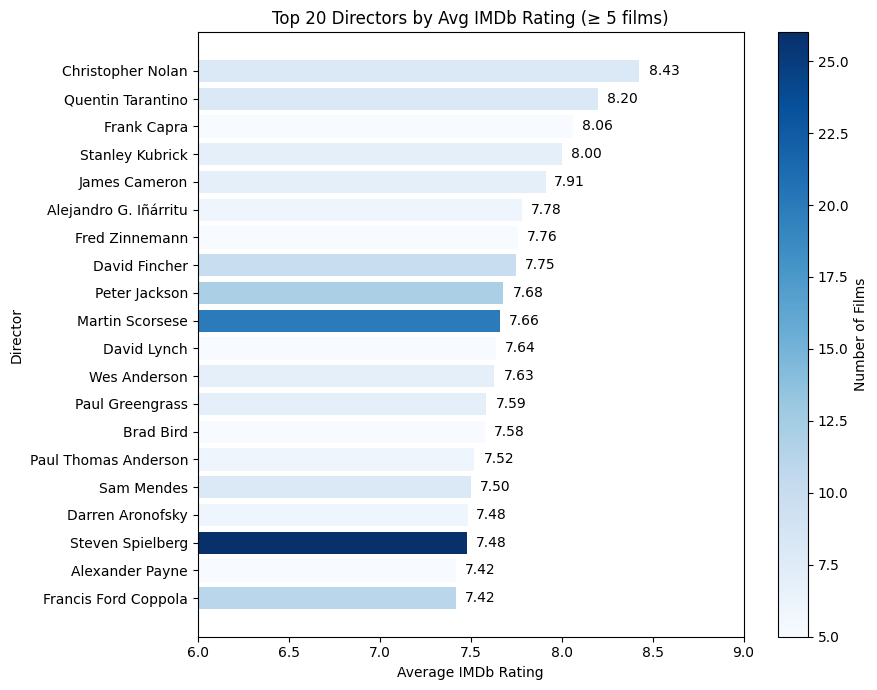

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm, colors as mcolors


MIN_FILMS = 5
TOP_N = 20


ranked = (directors_sql
          .query("films >= @MIN_FILMS")
          .sort_values(["avg_rating","films"], ascending = [False, False])
          .head(TOP_N)
          .copy())


ranked = ranked.iloc[::-1]  


norm = mcolors.Normalize(vmin = ranked["films"].min(), vmax = ranked["films"].max())
cmap = cm.Blues
bar_colors = cmap(norm(ranked["films"]))


fig, ax = plt.subplots(figsize = (9, 7))
ax.barh(ranked["director"], ranked["avg_rating"], color = bar_colors, edgecolor = "none")


for y, val in enumerate(ranked["avg_rating"].round(2)):
    ax.text(val + 0.05, y, f"{val:.2f}", va = "center")


ax.set_xlim(6.0, 9.0)  
ax.set_xlabel("Average IMDb Rating")
ax.set_ylabel("Director")
ax.set_title(f"Top {TOP_N} Directors by Avg IMDb Rating (≥ {MIN_FILMS} films)")


sm = cm.ScalarMappable(cmap = cmap, norm = norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Number of Films")

plt.tight_layout()
plt.savefig("../visuals/top_directors_avg_rating_topN.png", dpi = 200, bbox_inches = "tight")
plt.show()



### Query 8: Correlation Data Prep
This query extracts the three key variables needed for the correlation analysis: budget, gross revenue, and IMDb rating. Records with missing values are filtered ensuring the calculations are based only on numeric data. 

In [79]:
corr_df = df_budget_rev.merge(
    df_budget_rev[["year"]], on="year", how="left"
)

# but simpler: just grab from the raw movie_metadata table
with sqlite3.connect(db_path) as conn:
    df_corr = pd.read_sql_query("""
        SELECT budget, gross, imdb_score
        FROM movie_metadata
        WHERE budget IS NOT NULL
          AND gross IS NOT NULL
          AND imdb_score IS NOT NULL
    """, conn)

C = df_corr.corr(method="pearson")
labels = C.columns.tolist()


## Chart 8: Correlation Analysis Below: Budget, Revenue, and Rating
To explore the potential relationships between key variables, I computed a correlation matrix. This shows how strongly **budget**, **revenue**, and **IMDb ratings** move together. In this dataset, budget and revenue show only a weak positive correlation, while ratings have very little correlation with either. 

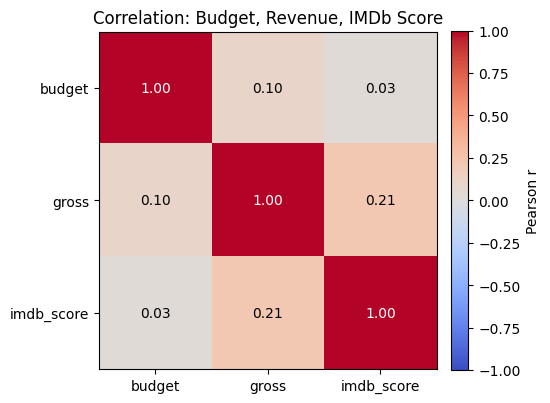

In [81]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5.6, 5.6))

im = ax.imshow(C, vmin=-1, vmax=1, cmap="coolwarm")
fig.colorbar(im, fraction=0.046, pad=0.04).set_label("Pearson r")

n = len(labels)
ax.set_xticks(range(n))
ax.set_yticks(range(n))
ax.set_xticklabels(labels, rotation=0)
ax.set_yticklabels(labels)
ax.set_title("Correlation: Budget, Revenue, IMDb Score")
ax.set_aspect("equal")

# annotate cells with values
for i in range(n):
    for j in range(n):
        ax.text(j, i, f"{C.iloc[i,j]:.2f}",
                ha="center", va="center",
                color="white" if abs(C.iloc[i,j]) > 0.5 else "black")

plt.tight_layout()
plt.savefig("figures/corr_heatmap_full.png", dpi=300, bbox_inches="tight")
plt.show()


### Data Step: Standardizing & Loading
The dataset uses slightly different column names depending on the source (IMDb TSV vs. Kaggle IMDb 5000 dataset). To remain consistent, columns were renamed to match what the queries would expect and saved into a `movies_clean' table inside SQLite for downstream analysis. 

In [5]:
df = df.rename(columns={
    "startYear": "start_year",
    "averageRating": "rating",
    "numVotes": "numVotes"
})



In [9]:
from pathlib import Path
import sqlite3, pandas as pd

# 1) Open your DB
db_path = Path("../data_processed/imdb_movies.db")
con = sqlite3.connect(db_path)

# 2) Load your cleaned file (parquet or csv)
parquet_path = Path("../data_processed/movies_clean.parquet")
csv_path     = Path("../data_processed/movies_clean.csv")

if parquet_path.exists():
    df = pd.read_parquet(parquet_path)
elif csv_path.exists():
    df = pd.read_csv(csv_path)
else:
    raise FileNotFoundError("Couldn't find movies_clean.parquet or movies_clean.csv in data_processed/")

# 3) Standardize column names to what the SQL expects
#    - Map common variants to: start_year, rating, numVotes
colmap = {
    "startYear": "start_year",   # IMDb TSV style
    "year": "start_year",        # your screenshot shows this
    "averageRating": "rating",   # IMDb TSV style
    "numVotes": "numVotes",      # already correct if present
    "num_voted_users": "numVotes" # Kaggle IMDB 5000 style
}
df = df.rename(columns={k: v for k, v in colmap.items() if k in df.columns})

# 4) If votes still missing, create a safe default (or drop rows)
if "numVotes" not in df.columns:
    # Try another common variant; otherwise fill 0
    if "num_user_for_reviews" in df.columns:
        # not ideal for voting, but better than failing—use zeros instead if you prefer
        df["numVotes"] = 0
    else:
        df["numVotes"] = 0  # conservative fallback

# 5) Minimal columns check
needed = {"start_year", "rating", "numVotes"}
missing = needed - set(df.columns)
if missing:
    raise ValueError(f"Still missing columns: {missing}. "
                     f"Available columns: {sorted(df.columns.tolist())[:25]} ...")

# 6) Type cleanup (year can be float; coerce to int)
df["start_year"] = pd.to_numeric(df["start_year"], errors="coerce").astype("Int64")
df["rating"]     = pd.to_numeric(df["rating"], errors="coerce")
df["numVotes"]   = pd.to_numeric(df["numVotes"], errors="coerce").fillna(0).astype("Int64")

# Optional: drop rows without year or rating
df = df.dropna(subset=["start_year", "rating"])

# 7) Write standardized table used by your SQL
df.to_sql("movies_clean", con, if_exists="replace", index=False)

# 8) Quick sanity check
print(pd.read_sql_query(
    "SELECT COUNT(*) AS rows, MIN(start_year) AS min_year, MAX(start_year) AS max_year FROM movies_clean", con
))



   rows  min_year  max_year
0  4813      1916      2016


### Query 9: Average Ratings by Decade (3 Decade Moving Average)
This query calculates the average IMDb rating for each decade and applies a simple 3 point moving average (previous/current/next decade), smoothing noise and revealing the underlying trend. 

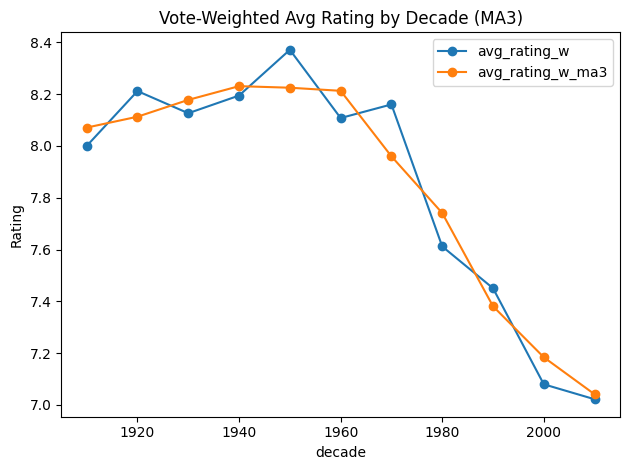

In [13]:
from pathlib import Path
import sqlite3, pandas as pd
import matplotlib.pyplot as plt

db_path = Path("../data_processed/imdb_movies.db")
con = sqlite3.connect(db_path)

sql_file = Path("../sql/02_ratings_trend_by_decade_w_ma.sql")
query = sql_file.read_text(encoding="utf-8")

ratings_trend_ma = pd.read_sql_query(query, con)

ax = ratings_trend_ma.plot(
    x="decade",
    y=["avg_rating_w", "avg_rating_w_ma3"],
    kind="line",
    marker="o"
)
ax.set_title("Vote-Weighted Avg Rating by Decade (MA3)")
ax.set_ylabel("Rating")
plt.tight_layout()
plt.show()


### Export: Ratings Trend Chart
To make sure visualizatio is reusable outside of the notebook, the chart is exported as a high-resolution PNG file into the `figures/` directory. 

In [22]:
out_dir = Path("../visuals")   
out_dir.mkdir(parents = True, exist_ok = True)

fig_path = out_dir / "ratings_trend_by_decade_ma3.png"
fig = ax.get_figure()
fig.savefig(fig_path, dpi = 300, bbox_inches = "tight")

print(f"Chart saved to: {fig_path}")


Chart saved to: ../visuals/ratings_trend_by_decade_ma3.png


### Debug: Locate SQLite DB
This helper step verifies the `imdb_movies.db` file can be found from the current working directory. It checks multiple possible paths and prints which one exists, preventing path errors later in the analysis. 

In [5]:
from pathlib import Path

print("CWD:", Path.cwd())

candidates = [
    Path("../data_processed/imdb_movies.db"),
    Path("./data_processed/imdb_movies.db"),
    Path("../../data_processed/imdb_movies.db"),
    Path("imdb_movies.db"),
]

for p in candidates:
    print(f"{p!s:40} -> exists? {p.exists()}")

hits = list(Path.cwd().glob("**/imdb_movies.db"))
print("\nFound via glob:", [str(h) for h in hits][:5])


CWD: /Users/mymac/Documents/DataProjects/IMDb-EndToEnd/notebooks
../data_processed/imdb_movies.db         -> exists? True
data_processed/imdb_movies.db            -> exists? False
../../data_processed/imdb_movies.db      -> exists? False
imdb_movies.db                           -> exists? False

Found via glob: []


### Export: Decade-Level Metrics for BI
This step aggregates IMDb ratings by decade and saves the results into the `bi_exports/` folder. The exported CSV (`decade_metrics.csv`) is designed for easy integration into BI tools such as Tableau or Power BI, enabling futher visualization and storytelling outside of this notebook. 

In [6]:
from pathlib import Path
import sqlite3
import pandas as pd


db_path = Path("../data_processed/imdb_movies.db")
out_dir = Path("../data_processed/bi_exports")
out_dir.mkdir(parents=True, exist_ok=True)

con = sqlite3.connect(db_path)


query = """
SELECT
    (start_year / 10) * 10 AS decade,
    AVG(rating) AS avg_rating_w
FROM movies_clean
WHERE start_year IS NOT NULL
GROUP BY decade
ORDER BY decade;
"""


ratings_trend_ma = pd.read_sql(query, con)

decade_metrics = ratings_trend_ma.copy()
decade_metrics.to_csv(out_dir / "decade_metrics.csv", index = False)

print(f"Decade metrics saved to: {out_dir / 'decade_metrics.csv'}")

con.close()


Decade metrics saved to: ../data_processed/bi_exports/decade_metrics.csv


### Export: Top Genres Metrics for BI
This export detects the genres column, splits multi-value entries(e.g., "Drama/Action"), and aggregates the Top 10 genres by movie count with average rating and total votes. 

In [ ]:
import pandas as pd

cols = pd.read_sql("PRAGMA table_info(movies_clean);", con)["name"].tolist()
if "genre" in cols:
    genre_col = "genre"
elif "genres" in cols:
    genre_col = "genres"
else:
    raise ValueError(
        "Neither 'genre' nor 'genres' exists in movies_clean. "
        "Run a quick inspect: SELECT * FROM movies_clean LIMIT 5;"
    )

query = f"""
WITH base AS (
  SELECT
    rowid AS rid,
    REPLACE(REPLACE(COALESCE({genre_col}, ''), '|', ','), '/', ',') || ',' AS g,  -- normalize sep to ','
    rating,
    numVotes
  FROM movies_clean
  WHERE {genre_col} IS NOT NULL AND TRIM({genre_col}) <> ''
),
split(rid, rating, numVotes, genre, rest) AS (
  SELECT
    rid, rating, numVotes,
    SUBSTR(g, 1, INSTR(g, ',') - 1) AS genre,
    SUBSTR(g, INSTR(g, ',') + 1)    AS rest
  FROM base
  UNION ALL
  SELECT
    rid, rating, numVotes,
    SUBSTR(rest, 1, INSTR(rest, ',') - 1),
    SUBSTR(rest, INSTR(rest, ',') + 1)
  FROM split
  WHERE rest <> ''
)
SELECT
  LOWER(TRIM(genre))           AS genre,
  COUNT(*)                     AS movie_count,
  AVG(rating)                  AS avg_rating,
  SUM(numVotes)                AS total_votes
FROM split
WHERE TRIM(genre) <> ''
GROUP BY LOWER(TRIM(genre))
ORDER BY movie_count DESC
LIMIT 10;
"""

top_genres = pd.read_sql(query, con)

out_path = out_dir / "top_genres_metrics.csv"
top_genres.to_csv(out_path, index = False)
print(f"Top genres metrics saved to: {out_path}")



Top genres metrics saved to: ../data_processed/bi_exports/top_genres_metrics.csv


## Conclusion & Next Steps
With decade-level and genre-level metrics exported into the `bi_exports/` folder, this notebook completes the data preparation phase. These outputs can now be used in BI tools (Tableau, Power BI, Excel) to create interactive dashboards and extend the storytelling. 

Future work may include: 
- Incorporating additional features (e.g., directors, revenue, or runtime). 
- Designing BI dashboards for trend comparisons. 
- Building a polished summary report notebook focused on narrative insights. 